## Import Libraries 

In this notebook we are going to try to classify the fake text using a logistic regression. 
You'll find : 
- A TF-IDF Matrix to extract features
- A Text Feature extraction

In [ ]:
import os
import pandas as pd
from langdetect import DetectorFactory
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
DetectorFactory.seed = 42
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

### Loading all the files

In [2]:
def read_texts_from_dir(dir_path:str) -> pd.DataFrame :
  """
  Reads the texts from a given directory and saves them in the pd.DataFrame with columns ['id', 'file_1', 'file_2'].

  Params:
    dir_path (str): path to the directory with data
  """
  dir_count = sum(os.path.isdir(os.path.join(root, d)) for root, dirs, _ in os.walk(dir_path) for d in dirs)
  data=[0 for _ in range(dir_count)]
  print(f"Number of directories: {dir_count}")

  # For each directory, read both file_1.txt and file_2.txt and save results to the list
  i=0
  for folder_name in sorted(os.listdir(dir_path)):
    folder_path = os.path.join(dir_path, folder_name)
    if os.path.isdir(folder_path):
      try:
        with open(os.path.join(folder_path, 'file_1.txt'), 'r', encoding='utf-8') as f1:
          text1 = f1.read().strip()
        with open(os.path.join(folder_path, 'file_2.txt'), 'r', encoding='utf-8') as f2:
          text2 = f2.read().strip()
        index = int(folder_name[-4:])
        data[i]=(index, text1, text2)
        i+=1
      except Exception as e:
        print(f"Error reading directory {folder_name}: {e}")
  df = pd.DataFrame(data, columns=['id', 'file_1', 'file_2']).set_index('id')
  return df

In [3]:
# Load the training data
train_path = "../data/train"
train_data = read_texts_from_dir(train_path)

# Load the test data 
test_path="../data/test"
test_data=read_texts_from_dir(test_path)


Number of directories: 95
Number of directories: 1068


In [4]:
train_data.head()

,file_1,file_2
id,,
0,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,China\nThe goal of this project involves achie...,The project aims to achieve an accuracy level ...
2,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,China\nThe study suggests that multiple star s...,The importance for understanding how stars evo...
4,Dinosaur Rex was excited about his new toy set...,Analyzing how fast stars rotate within a galax...


In [5]:
# Load the training ground truth labels
df_train_gt=pd.read_csv("../data/train.csv")
df_train_gt

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2
...,...,...
90,90,2
91,91,1
92,92,2
93,93,2


The class are balanced, so any model can learn from the two classes.

In [6]:
df_train_gt["real_text_id"].value_counts()


real_text_id
2    49
1    46
Name: count, dtype: int64

### Simple Exploratory Data Analysis

We perform this data analysis to see if a simple rule model could properly classify texts.

There are not difference between the length of text 1 and text 2 when they are true

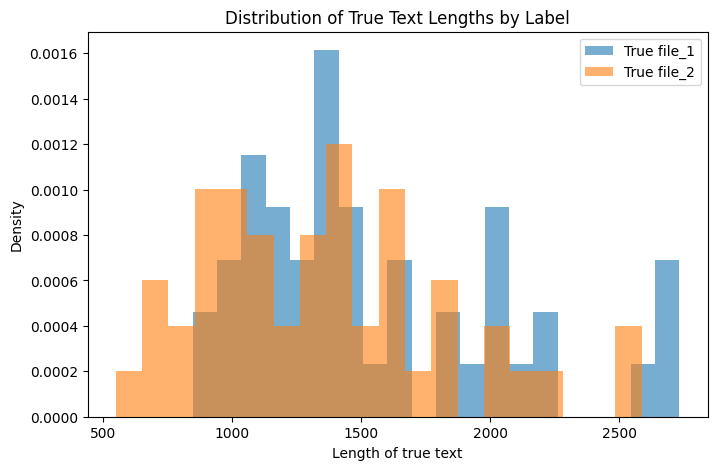

In [7]:
def plot_length_text_per_category(train_data:pd.DataFrame, ground_truth: pd.DataFrame)-> None:
  """
  Plots the length of texts in file_1 and file_2 .

  Params:
    train_data (pd.DataFrame): DataFrame with columns ['file_1', 'file_2'] indexed by 'id'.
    ground_truth (pd.DataFrame): DataFrame with columns ['id', 'real_text_id'].
  """
  merged_data = train_data.merge(ground_truth, left_index=True, right_on='id')

  df = merged_data.copy()
  df["true_text"] = df.apply(
      lambda row: row["file_1"] if row["real_text_id"] == 1 else row["file_2"], axis=1
  )
  df["true_length"] = df["true_text"].str.len()

  df_label1 = df[df["real_text_id"] == 1]
  df_label2 = df[df["real_text_id"] == 2]

  # These values are from value_counts() above
  assert df_label2.shape[0] == 49
  assert df_label1.shape[0] == 46

  plt.figure(figsize=(8, 5))
  plt.hist(df_label1["true_length"], bins=20, alpha=0.6, label="True file_1", density=True)
  plt.hist(df_label2["true_length"], bins=20, alpha=0.6, label="True file_2", density=True)

  plt.xlabel("Length of true text")
  plt.ylabel("Density")
  plt.title("Distribution of True Text Lengths by Label")
  plt.legend()
  plt.show()

plot_length_text_per_category(train_data, df_train_gt)

In [8]:
train_data.isnull().sum()

file_1    0
file_2    0
dtype: int64

In [9]:
train_data.duplicated().sum()

np.int64(0)

In [10]:
train_data.map(lambda x: [len(x), type(x.strip())])

,file_1,file_2
id,,
0,"[2196, <class 'str'>]","[2018, <class 'str'>]"
1,"[3124, <class 'str'>]","[936, <class 'str'>]"
2,"[1139, <class 'str'>]","[801, <class 'str'>]"
3,"[1774, <class 'str'>]","[1869, <class 'str'>]"
4,"[195, <class 'str'>]","[871, <class 'str'>]"
...,...,...
90,"[2281, <class 'str'>]","[2146, <class 'str'>]"
91,"[1986, <class 'str'>]","[2038, <class 'str'>]"
92,"[8925, <class 'str'>]","[1128, <class 'str'>]"


### Preprocess text

In [17]:
LEMMATIZER = WordNetLemmatizer()
def preprocess_text(text:str) -> str:
  """
  Preprocesses the text data by , converting to lowercase, lemmatizing, and removing stopwords.

  Params:
    dataframe (pd.DataFrame): DataFrame with columns ['file_1', 'file_2'] indexed by 'id'.
  
  Returns:
    pd.DataFrame: Preprocessed DataFrame.
  """

  text = text.lower()
  text = LEMMATIZER.lemmatize(text)
  return " ".join([word for word in text.split() if word not in stopwords.words('english')])


In [43]:
import numpy as np

Extract features

In [ ]:
def extract_text_features(text):
    """Extract various text features from a given text string"""
    
    text_len = len(text)
    word_count = len(text.split())
    char_count = len(text.replace(' ', ''))
    
    # Vocabulary features
    words = text.lower().split()
    unique_words = len(set(words))
    vocab_richness = unique_words / word_count if word_count > 0 else 0
    
    # Character composition features
    alpha_chars = sum(c.isalpha() for c in text)
    digit_chars = sum(c.isdigit() for c in text)
    space_chars = sum(c.isspace() for c in text)
    special_chars = len(text) - alpha_chars - digit_chars - space_chars

    # Ratios
    alpha_ratio = alpha_chars / len(text) if len(text) > 0 else 0
    digit_ratio = digit_chars / len(text) if len(text) > 0 else 0
    special_ratio = special_chars / len(text) if len(text) > 0 else 0

    return np.array([ text_len, word_count, char_count, unique_words, vocab_richness, alpha_ratio, digit_ratio, special_ratio ])


In [ ]:
def extract_tfidf_features(corpus, max_features=1000):
    """Extract TF-IDF features from a list of text documents"""
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_all = vectorizer.fit_transform(texts)

    return X_tfidf.toarray(), vectorizer

### We will try a logistic regression on heuristics

In [18]:

def train_logistic_regression(train_data:pd.DataFrame, df_train_gt:pd.DataFrame) -> tuple:
    """
    Trains a logistic regression model to classify which of the two texts is real.

    Params:
    train_data (pd.DataFrame): DataFrame with columns ['file_1', 'file_2'] indexed by 'id'.
    df_train_gt (pd.DataFrame): DataFrame with columns ['id', 'real_text_id'].
    """
    merged_data = train_data.merge(df_train_gt, left_index=True, right_on='id')
    texts = merged_data["file_1"].tolist() + merged_data["file_2"].tolist()

    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
    X_all = vectorizer.fit_transform(texts)

    n = len(merged_data)
    X1, X2 = X_all[:n], X_all[n:]   # split back into file_1 and file_2

    X = X1 - X2
    y = (merged_data["real_text_id"] == 1).astype(int)  # 1 if file_1 is real, 0 if file_2 is real

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    return clf, vectorizer


In [19]:
logistic_regression, tfidf_vectorizer = train_logistic_regression(train_data, df_train_gt)

Accuracy: 0.9310344827586207


### Predict on test data

In [21]:
test_texts = test_data["file_1"].tolist() + test_data["file_2"].tolist()

In [22]:
X_test = tfidf_vectorizer.transform(test_texts)

In [36]:
n = len(test_data)
X1, X2 = X_test[:n], X_test[n:] 
X = X1 - X2

In [37]:
y_pred = logistic_regression.predict(X)

In [41]:
submission_df = pd.DataFrame({
    "id": ids,
    "real_text_id": y_pred
})


In [42]:
submission_df.to_csv("../data/submission.csv", index=False)

In [ ]:
len()